# Lets Load in the Data and Do ML

In [15]:
import pandas as pd

csv_file = pd.read_csv('Full_File.csv', index_col=0)
df = pd.DataFrame(csv_file)
X = df.drop(['CH', 'C=C', 'C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H'], axis=1)
y = df[['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']]



Rows with any NaN value:
Empty DataFrame
Columns: [CH, C=C, C≡C, C≡N, C-OH, C=O, C=OOH, N-H, C≡C-H]
Index: []


In [16]:
#Now let's follow the typical ML workflow

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
#Stratify   
mskf = MultilabelStratifiedKFold(n_splits=8, shuffle=True, random_state=22)
for train_idx, test_idx in mskf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    break  

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)


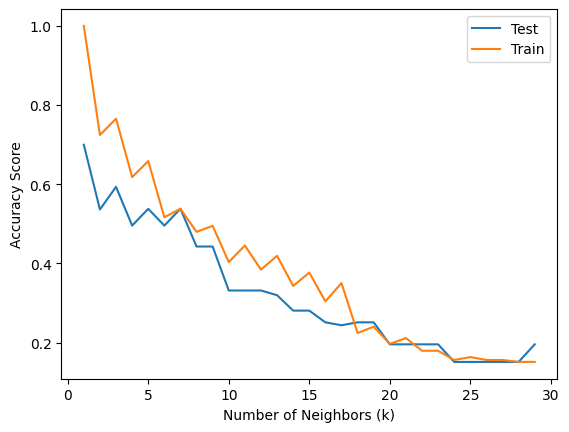

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
test_accuracy=[]
train_accuracy = []
kl=[]
for k in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_train_pred = neigh.predict(X_train)
    y_test_pred = neigh.predict(X_test)
    train_accuracy.append(f1_score(y_train, y_train_pred, average='macro'))
    test_accuracy.append(f1_score(y_test, y_test_pred, average='macro'))
    kl.append(k)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.plot(kl, test_accuracy, label='Test')
plt.plot(kl, train_accuracy, label='Train')
plt.legend()




In [19]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_train_pred = neigh.predict(X_train)
y_test_pred = neigh.predict(X_test)
print("Test F1 Macro:", f1_score(y_test, y_test_pred, average='macro'))
print("Test F1 Micro:", f1_score(y_test, y_test_pred, average='micro'))


Test F1 Macro: 0.5934391534391534
Test F1 Micro: 0.8


In [20]:
#Let's try logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
reg = LogisticRegression(solver='liblinear', C=1, class_weight='balanced', max_iter=1000, penalty='l2')
multi_label = OneVsRestClassifier(reg)
multi_label.fit(X_train, y_train)
print("Train:", multi_label.score(X_train, y_train))
print("Test:", multi_label.score(X_test, y_test))
y_train_pred = multi_label.predict(X_train)
y_test_pred_prob = multi_label.predict_proba(X_test)
y_test_pred = multi_label.predict(X_test)

print("Macro F1:", f1_score(y_test, y_test_pred, average='macro'))
print("Micro F1:", f1_score(y_test, y_test_pred, average='micro'))
print('accuracy_score:', accuracy_score(y_test, y_test_pred))


Train: 0.5
Test: 0.38461538461538464
Macro F1: 0.7332098765432099
Micro F1: 0.84375
accuracy_score: 0.38461538461538464


In [21]:
#Now let's try Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42))
clf.fit(X_train, y_train)
print("Train:", clf.score(X_train, y_train))
print("Test:", clf.score(X_test, y_test))
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print("Macro F1:", f1_score(y_test, y_test_pred, average='macro'))
print("Micro F1:", f1_score(y_test, y_test_pred, average='micro'))
print('accuracy_score:', accuracy_score(y_test, y_test_pred))   

Train: 1.0
Test: 0.38461538461538464
Macro F1: 0.7093121693121693
Micro F1: 0.847457627118644
accuracy_score: 0.38461538461538464


In [22]:
#Individual Predictions 
functional = ['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H']
name = 'propanenitrile_2methyl'
df_hex = pd.DataFrame(X.loc[name]).T
knn_pred = neigh.predict(df_hex)
knn_l = []
log_reg_pred = multi_label.predict(df_hex)
lr_l = []
random_forest_pred = clf.predict(df_hex)
rf_l = []
correct = y.loc[name].T
cr_l = []
for funct, knn, log, rf, cr in zip(functional, knn_pred[0], log_reg_pred[0], random_forest_pred[0], correct):
    if knn == 1:
        knn_l.append(funct)
    if log == 1:
        lr_l.append(funct)
    if rf == 1:
        rf_l.append(funct)
    if cr == 1:
        cr_l.append(funct)
print(X_test.index)
if name in X_train.index:
    print('In Training Set')
else: 
    print('Not in Training Set')
print('Correct Fx Group:', cr_l)
print('KNN Fx Group:', knn_l)
print('Log Reg Fx Group:', lr_l)
print('Random Forest Fx Group:', rf_l)

Index(['Urea', '1_5hexadiene3ol', 'cyclohexylamine', 'acetone',
       '2-cyclohexen-1-ol', 'propanenitrile', 'but-2-ene',
       'cyclopentylcyanide', '2_methylpropanenitrile', '2_Butene_E',
       'propargyl_alcohol', 'octanoic_acid', 'cyclopentylacetylene'],
      dtype='object', name='Name')
In Training Set
Correct Fx Group: ['CH', 'C≡N']
KNN Fx Group: ['CH']
Log Reg Fx Group: ['CH']
Random Forest Fx Group: ['CH', 'C≡N']


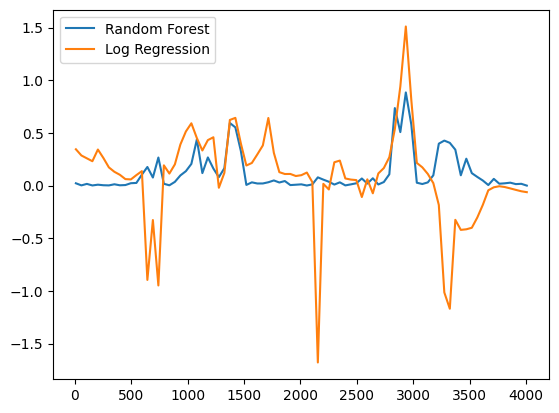

In [23]:
funct = ['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']
wave_numbers = X.columns.astype(float)
estimators = clf.estimators_
importance = []
wave_numbers = X.columns.astype(float)
estimators_ml = multi_label.estimators_
importance_o = []
funct_num = 0
for j, k in zip(estimators[funct_num].feature_importances_, estimators_ml[funct_num].coef_[0]):
    if k < 0:
        k = k
    importance_o.append(k)
    importance.append(j*10)
plt.plot(wave_numbers, importance, label='Random Forest')
plt.plot(wave_numbers, importance_o, label='Log Regression')
plt.legend()


/Users/bwclark/opt/anaconda3/envs/DS_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Forest Fx Group: ['CH', 'N-H']
Correct Fx Group: ['CH', 'N-H']


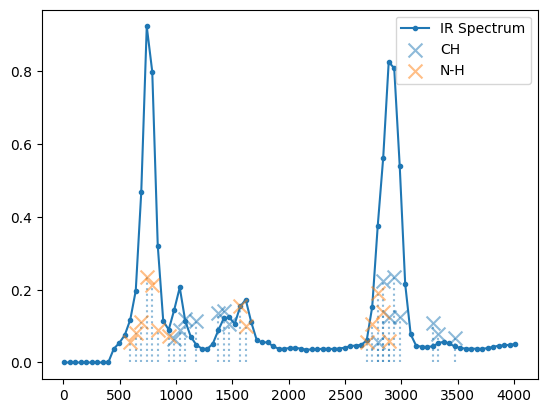

In [24]:
import shap
name = 'methylamine'
funct_d = {'CH':0,'C=C':1,'C≡C':2, 'C≡N':3, 'C-OH':4,'C=O':5, 'C=OOH':6, 'N-H':7, 'C≡C-H':8}
functionals = ['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']

df_hex = pd.DataFrame(X.loc[name]).T
random_forest_pred = clf.predict(df_hex)
rf_l = []
correct = y.loc[name].T
cr_l = []
for funct, rf, cr in zip(functionals, random_forest_pred[0], correct):
    if rf == 1:
        rf_l.append(funct)
    if cr == 1:
        cr_l.append(funct)
print('Random Forest Fx Group:', rf_l)
print('Correct Fx Group:', cr_l)
fig, ax = plt.subplots()
ax.plot(wave_numbers, df_hex.values[0], label='IR Spectrum', alpha=1, marker='.')
for k in rf_l:
    explainer = shap.TreeExplainer(clf.estimators_[funct_d[k]])
    shap_values = explainer.shap_values(df_hex)*5
    wave_numbers_shap = list(wave_numbers)
    of_interest = list(shap_values[0,:,1])
    for i in shap_values[0,:,1]:
        if abs(i) < 0.05:
            del wave_numbers_shap[of_interest.index(i)]
            of_interest.remove(i)
    ax.scatter(wave_numbers_shap, of_interest, label=k, alpha=0.5, marker='x', s=100, zorder=2)
    ax.vlines(x=wave_numbers_shap, ymax=of_interest, ymin=0, linestyles='dotted', alpha=0.5, zorder=1)
plt.legend()

Log Reg Fx Group: ['CH', 'N-H']
Correct Fx Group: ['CH', 'N-H']


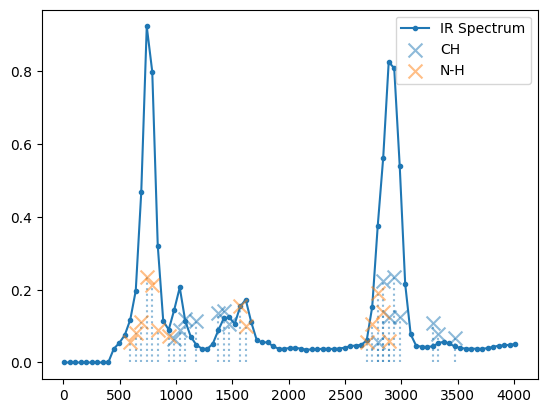

In [25]:
#Log Reg Code: 
import shap
name = 'methylamine'
funct_d = {'CH':0,'C=C':1,'C≡C':2, 'C≡N':3, 'C-OH':4,'C=O':5, 'C=OOH':6, 'N-H':7, 'C≡C-H':8}
functionals = ['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']

df_hex = pd.DataFrame(X.loc[name]).T
log_reg_pred = multi_label.predict(df_hex)
lr_l = []
correct = y.loc[name].T
cr_l = []
for funct, lr, cr in zip(functionals, log_reg_pred[0], correct):
    if lr == 1:
        lr_l.append(funct)
    if cr == 1:
        cr_l.append(funct)
print('Log Reg Fx Group:', rf_l)
print('Correct Fx Group:', cr_l)
fig, ax = plt.subplots()
ax.plot(wave_numbers, df_hex.values[0], label='IR Spectrum', alpha=1, marker='.')
for k in rf_l:
    explainer = shap.TreeExplainer(clf.estimators_[funct_d[k]])
    shap_values = explainer.shap_values(df_hex)*5
    wave_numbers_shap = list(wave_numbers)
    of_interest = list(shap_values[0,:,1])
    for i in shap_values[0,:,1]:
        if abs(i) < 0.05:
            del wave_numbers_shap[of_interest.index(i)]
            of_interest.remove(i)
    ax.scatter(wave_numbers_shap, of_interest, label=k, alpha=0.5, marker='x', s=100, zorder=2)
    ax.vlines(x=wave_numbers_shap, ymax=of_interest, ymin=0, linestyles='dotted', alpha=0.5, zorder=1)
plt.legend()